# Clase 2
[notebook](https://campus.exactas.uba.ar/mod/url/view.php?id=224044) original en Campus.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.linalg import inv

# Ejercicio 1

Reproduzca la figura 4.2 del libro *ISLR*:

*  Estime la probabilidad de `default` mediante un modelo lineal basado en variable `balance`. 
*  Grafique la probabilidad estimada en función de `balance` junto con las observaciones de la muestra.
*  Repita el gráfico para un modelo logístico.

**Sugerencia:** considere el comando `glm` con el argumento `family="binomial"`. ¿Qué significa `family="gaussian"`?


In [2]:
default = pd.read_csv("default.csv")

In [41]:
X = np.column_stack([
    np.repeat(1, len(default)),
    default.balance,
])
y = np.where(default.default == "Yes", 1, 0)

In [42]:
lin_model = sm.GLM(y, X, family=sm.families.Gaussian())
lin_fit = lin_model.fit()
print(lin_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                        0.028251
Method:                          IRLS   Log-Likelihood:                 3644.8
Date:                Sun, 31 Oct 2021   Deviance:                       282.45
Time:                        12:33:13   Pearson chi2:                     282.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0752      0.003    -22.416      0.0

In [43]:
log_model = sm.GLM(y, X, family=sm.families.Binomial())
log_fit = log_model.fit()
print(log_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -798.23
Date:                Sun, 31 Oct 2021   Deviance:                       1596.5
Time:                        12:33:13   Pearson chi2:                 7.15e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6513      0.361    -29.491      0.0

In [6]:
grid_size = 1000
grid = np.column_stack([
    np.repeat(1, grid_size),
    np.linspace(0, default.balance.max(), grid_size)
])

In [7]:
lin_pred = lin_fit.predict(grid)
log_pred = log_fit.predict(grid)

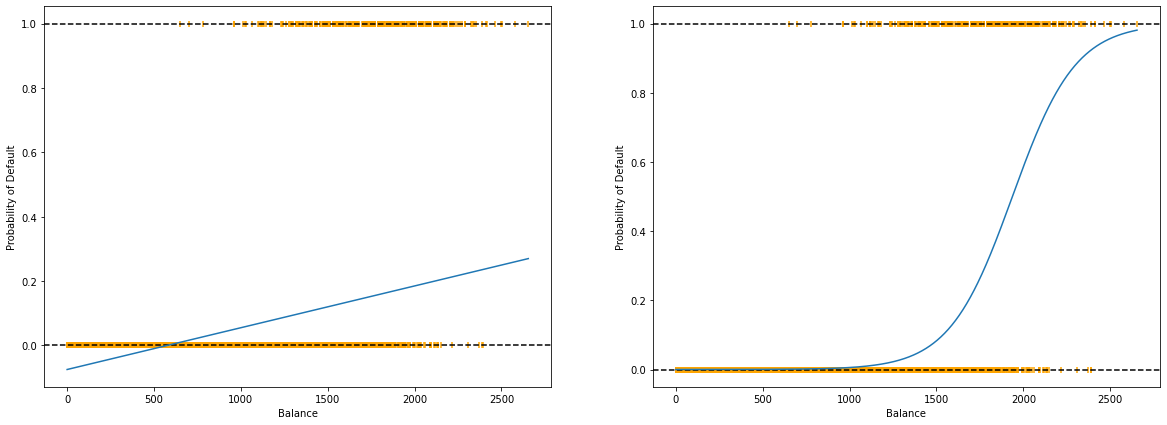

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
for ax, pred in zip(axs, [lin_pred, log_pred]):
    [ax.axhline(y, linestyle="dashed", color="black") for y in (0, 1)]
    ax.scatter(default.balance, y, marker="|", color="orange")
    ax.set_xlabel("Balance")
    ax.set_ylabel("Probability of Default")
    ax.plot(grid[:, 1], pred)
plt.show()

# Ejercicio 2

* Implemente una función que realice una regresión logística múltiple, para el caso de dos clases, y devuelva los coeficientes estimados y las probabilidades estimadas. 
* Compare con la salida del comando `glm` usando las *features* `balance` e `income`.
* (*) Agregue a su función los errores estándar e intervalos de confianza para los parámetros (compare con la salida del comando `confint`)

**Sugerencias:** 
* considere el comando `optim` para maximizar la función de verosimilitud,
* tenga cuidado con la escala de las variables,
* vincule la varianza asintótica del estimador de máxima verosimilitud con el argumento `hessian` del comando `optim`.


In [9]:
from scipy.stats import norm

In [15]:
bernoulli.pmf(0, 0.4)

0.6

In [33]:
norm.rvs(size=3)

array([ 0.81593806,  0.48008113, -2.35166468])

In [72]:
poisson.logpmf(1, 1)

-1.0

In [220]:
np.exp(11356, dtype=np.float128)

7.049145799985662438e+4931

Es realmente difícil - prácticamente imposible - implementar algoritmos que sin manipular los datos iniciales para llevarlos a escalas razonables, y luego hacer un uso inteligente de las propiedades de disitntas funciones,
- no se topen con "overflows" (valores más grandes de los que el computador puede representar) y
- tarden una cantidad razonable de tiempo.

Por eso, aunque uno podría definir una función de log-verosimilitud (`loglikelihood`) genérica como 
```python
sum([logpdf(y, theta) for y, theta in zip(y, X @ beta)])
```
, elegimos definir a mano una función que se lleve bien con `scipy.optimize.minimize`.

In [284]:
from scipy.stats import norm, binom, poisson, bernoulli

def np_exp(x):
    """Use 128bits floats to avoid overflows when computing logloss"""
    return np.exp(x, dtype=np.float128)

def identity(x):
    return x

def logistic(x):
    return np_exp(x) / (1 + np_exp(x))

class GLM():
    
    LINKS = {"gaussian": identity, "bernoulli": logistic, "poisson": np_exp}
    
    def __init__(self, X, y, family="gaussian"):
        if family not in self.LINKS.keys():
            raise ValueError(f"{family} is not a recognised family. Try one of {list(self.LINKS)}")
        self.X = X
        self.y = y
        self.family = family
        self.link = self.LINKS[family]
        
    def loglikelihood(self, beta):
        theta = self.X @ beta  # @ is the internal product <X, beta>
        # These are calculated by hand, and each representes the part of the log-likelihood function
        # than is affected by the choice of coefficients `beta` (via theta)
        if self.family == "gaussian":
            return - sum((self.y - theta) ** 2)
        elif self.family == "bernoulli":
            return sum(- np.log(1 + np_exp(theta)) + self.y * theta)
        elif self.family == "poisson":
            return sum(self.y * theta - np_exp(theta))
        else:
            raise NotImplementedError
        
    def fit(self):
        self.res_ = minimize(
            fun=lambda beta: -self.loglikelihood(beta),
            # Start at something different from all-zeroes for conditioning reasons
            x0=np.zeros(self.X.shape[1])#norm.rvs(size=self.X.shape[1], scale=0.01),
        )
        self.coefs_ = self.res_.x
        self.coefs_sd_ = np.diag(self.res_.hess_inv) ** .5
        self.y_ = self.predict()


    def predict(self, X=None):
        X = X or self.X  # predict on the original data if there's no new data
        return self.link(X @ self.coefs_)
    
    def confint(self, p):
        """Return 100 * p % confidence interval for `coefs` """
        phi = norm.ppf((1 - p) /2)
        return [
            (c + phi * sd, c - phi * sd)
            for c, sd in zip (self.coefs_, self.coefs_sd_)
        ]

In [285]:
X = np.column_stack([
    np.repeat(1, len(default)),
    default.balance,
    default.income,
])

In [286]:
# idxs = np.random.choice(range(len(y)), 10000, replace=False)
idxs = np.arange(len(y))

In [288]:
my_model = GLM(X[idxs,], y[idxs], "bernoulli")
my_model.fit()

In [295]:
my_model.coefs_, my_model.coefs_sd_, my_model.confint(0.95)

(array([-1.15382473e+01,  5.64661731e-03,  2.07675181e-05]),
 array([4.61976692e-01, 2.37637324e-04, 5.32899716e-06]),
 [(-12.443704945878082, -10.632789588894024),
  (0.0051808567108926765, 0.0061123779047683345),
  (1.0322875546083746e-05, 3.1212160570689596e-05)])

In [291]:
lin_model = sm.GLM(y[idxs], X[idxs], family=sm.families.Binomial())
lin_fit = lin_model.fit()
print(lin_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Sun, 31 Oct 2021   Deviance:                       1579.0
Time:                        21:37:34   Pearson chi2:                 6.95e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.0

In [65]:
sm_model = sm.GLM(y, X, family=sm.families.Binomial())
sm_fit = sm_model.fit()
print(sm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -789.48
Date:                Sat, 30 Oct 2021   Deviance:                       1579.0
Time:                        17:41:50   Pearson chi2:                 6.95e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.0

Los coeficientes de statsmodels.GLM para familia binomial, y los de nuestra función caserita, RegLog, tienen una diferencia relativa menor al 1%.

In [53]:
my_model.coefs_, sm_fit.params

(array([-1.15382420e+01,  5.64661478e-03,  2.07674853e-05]),
 array([-1.15404684e+01,  5.64710295e-03,  2.08089755e-05]))

In [14]:
assert np.allclose(my_model.coefs_, sm_fit.params, rtol=1e-2)

In [31]:
np.diag(sm_fit.cov_params()) ** .5, my_model.coefs_sd_

(array([4.34772469e-01, 2.27381384e-04, 4.98524546e-06]),
 array([4.62072056e-01, 2.37686009e-04, 5.32896951e-06]))

## Ejercicio de fin de clase
1. Modelar una Regresión lineal para el dataset Bikeshare.
2. Modelar una Regresión Poisson para el dataset Bikeshare.
3. Comparar los resultados obtenidos entre los dos modelos.

In [297]:
bike = pd.read_csv("bikeshare.csv")

In [298]:
bike

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
0,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0000,3,13,16
1,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0000,8,32,40
2,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0000,5,27,32
3,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0000,3,10,13
4,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,1,Dec,365,19,0,6,0,clear,0.42,0.4242,0.54,0.2239,19,73,92
8641,1,Dec,365,20,0,6,0,clear,0.42,0.4242,0.54,0.2239,8,63,71
8642,1,Dec,365,21,0,6,0,clear,0.40,0.4091,0.58,0.1940,2,50,52
8643,1,Dec,365,22,0,6,0,clear,0.38,0.3939,0.62,0.1343,2,36,38


In [299]:
X = np.column_stack([
    np.repeat(1, len(bike)),
    bike.weekday,
    bike.hr,
    bike.temp,
])
y = bike.bikers

In [286]:
# idxs = np.random.choice(range(len(y)), 10000, replace=False)
idxs = np.arange(len(y))

In [301]:
my_model = GLM(X, y, "poisson")
my_model.fit()

In [302]:
my_model.coefs_, my_model.coefs_sd_, my_model.confint(0.95)

(array([3.21425253, 0.00644106, 0.05221665, 1.99433096]),
 array([0.00366894, 0.00043548, 0.000136  , 0.00474422]),
 [(3.20706154310758, 3.221443520225647),
  (0.005587532907482795, 0.007294588662821566),
  (0.05195008283318116, 0.052483208142523705),
  (1.9850324563090251, 2.003629465145264)])

In [312]:
sm_model = sm.GLM(y, X, family=sm.families.Poisson())
sm_fit = sm_model.fit()
print(sm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 bikers   No. Observations:                 8645
Model:                            GLM   Df Residuals:                     8641
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.6975e+05
Date:                Sun, 31 Oct 2021   Deviance:                   6.8646e+05
Time:                        21:56:07   Pearson chi2:                 7.45e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2143      0.004    878.552      0.0

<AxesSubplot:xlabel='hr'>

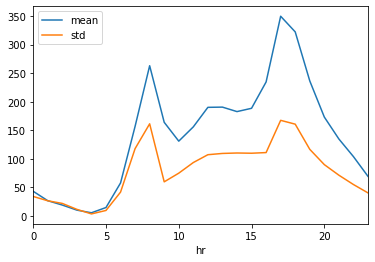

In [80]:
bike.groupby("hr").bikers.agg([np.mean, np.std]).plot()